Assignment by Himank

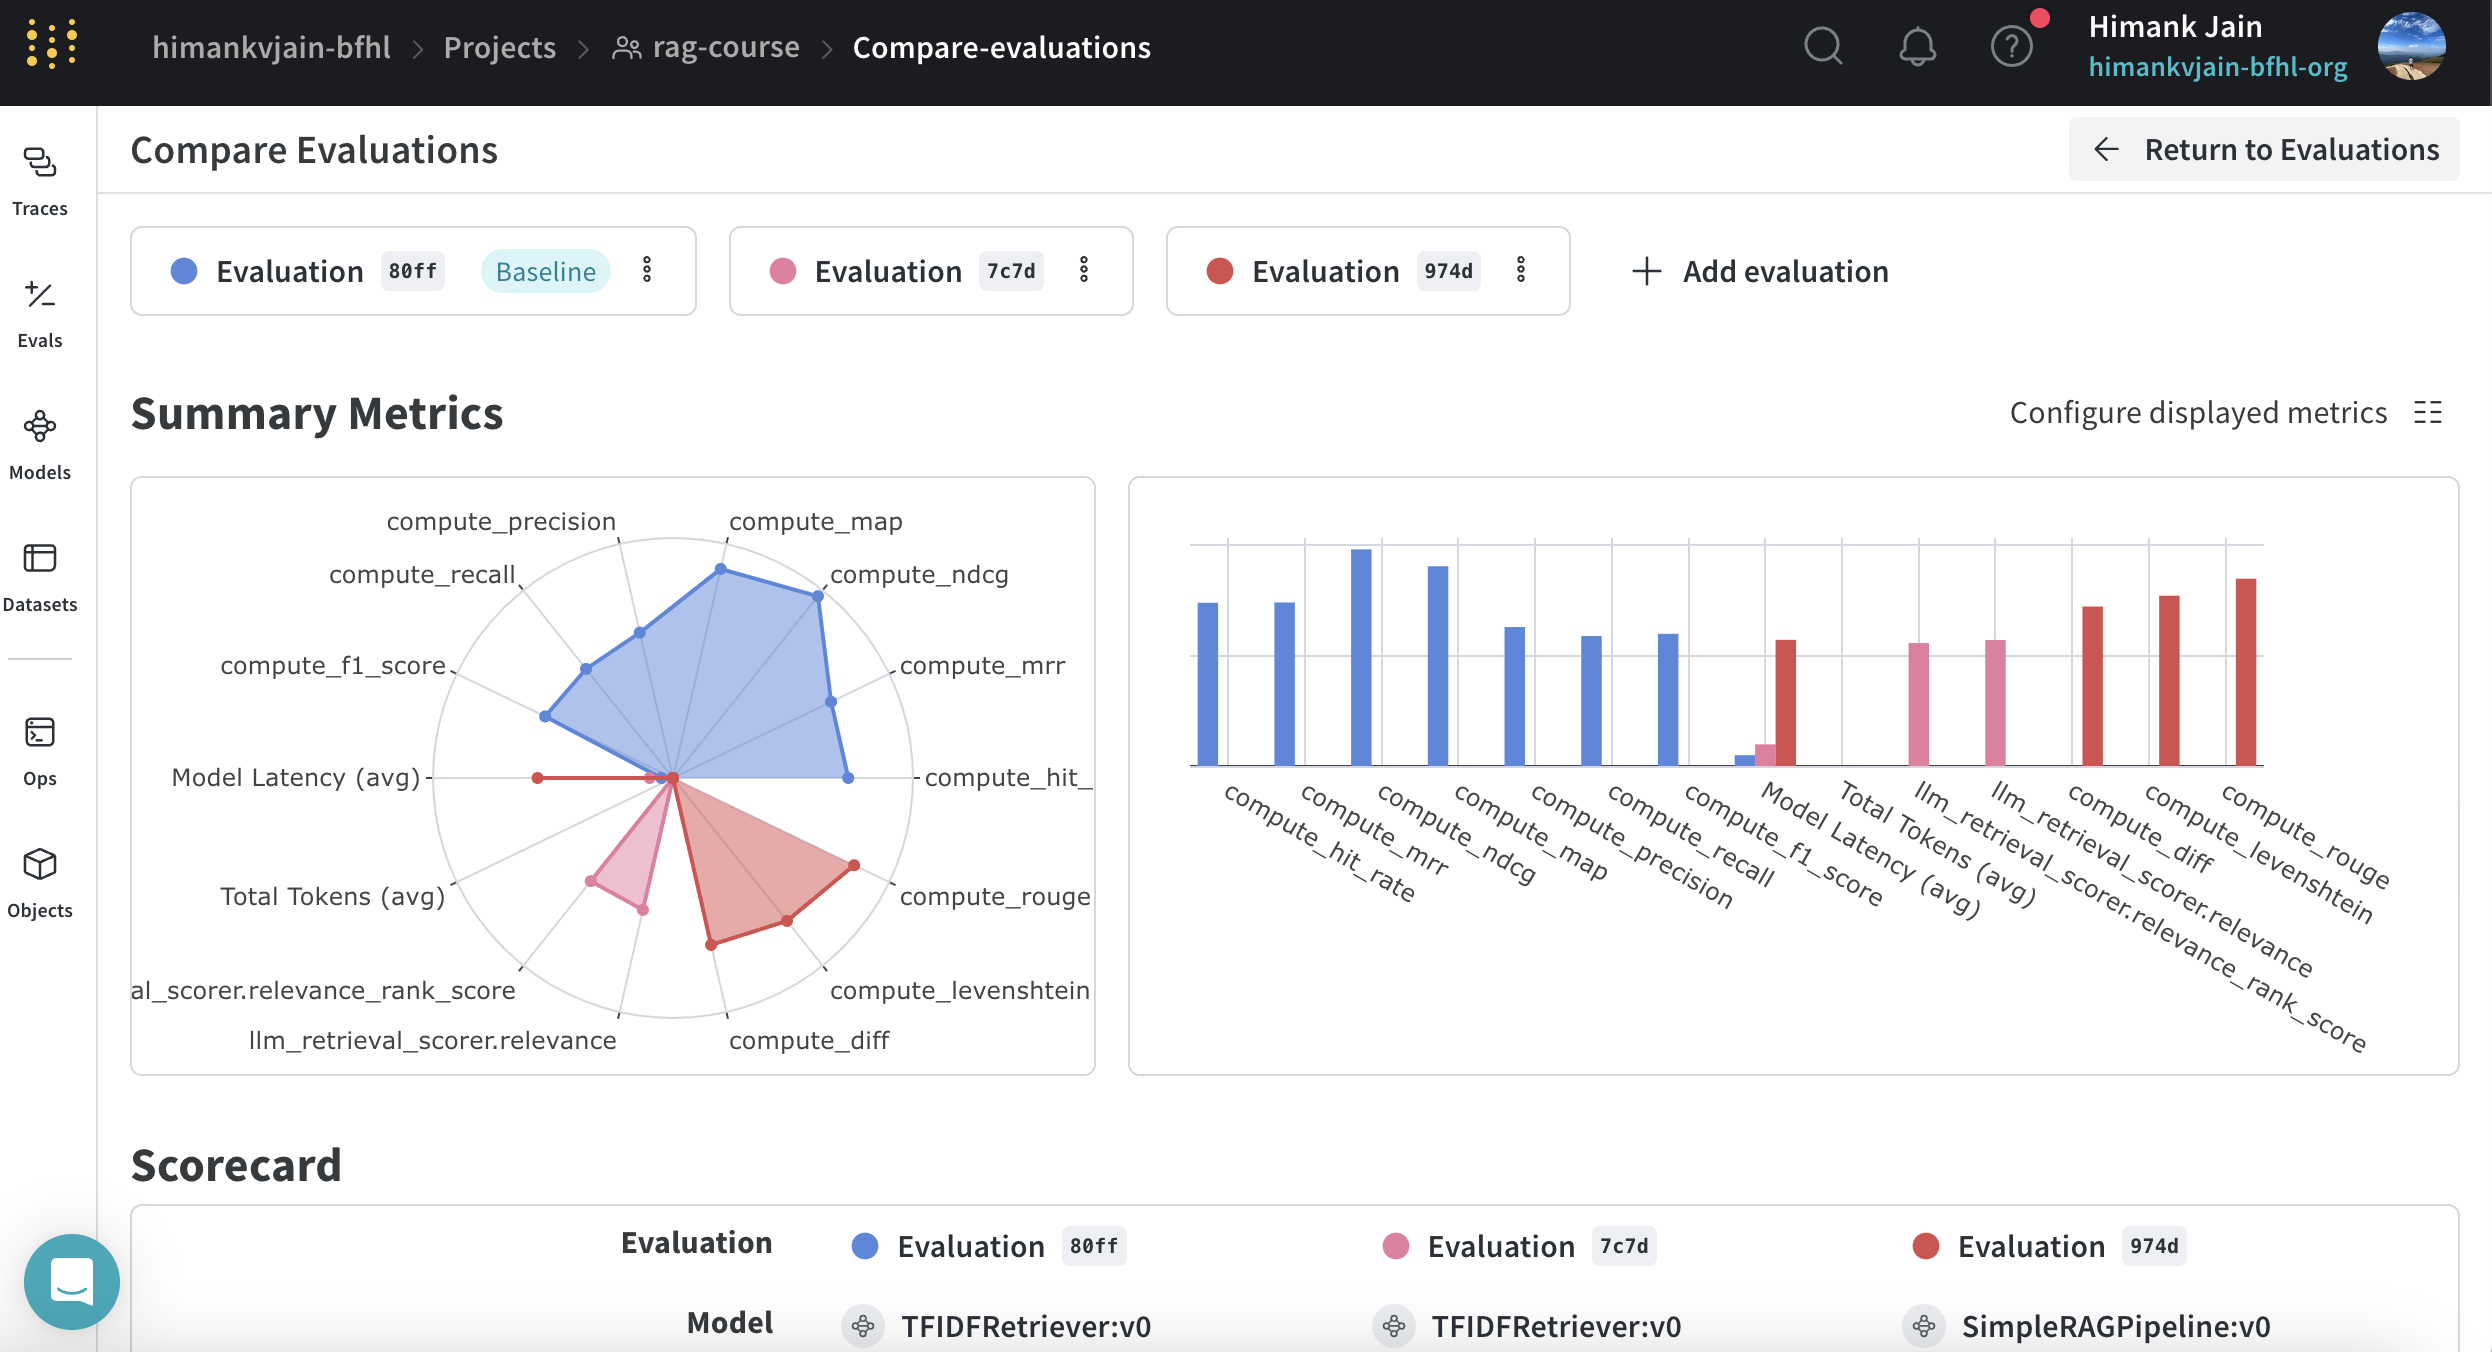

[Dashboard](https://wandb.ai/himankvjain-bfhl/rag-course/weave/compare-evaluations?evaluationCallIds=%5B%220192e7e4-5098-7442-ae84-d78fbe1480ff%22%2C%220192e7e4-b9b1-7142-9ac0-a9ed76f37c7d%22%2C%220192e7e5-ab13-7002-a730-48873a68974d%22%5D&metrics=%7B%22compute_hit_rate%22%3Atrue%2C%22compute_mrr%22%3Atrue%2C%22compute_ndcg%22%3Atrue%2C%22compute_map%22%3Atrue%2C%22compute_precision%22%3Atrue%2C%22compute_recall%22%3Atrue%2C%22compute_f1_score%22%3Atrue%2C%22Model%20Latency%20(avg)%22%3Atrue%2C%22Total%20Tokens%20(avg)%22%3Atrue%2C%22llm_retrieval_scorer.relevance_rank_score%22%3Atrue%2C%22llm_retrieval_scorer.relevance%22%3Atrue%2C%22compute_diff%22%3Atrue%2C%22compute_levenshtein%22%3Atrue%2C%22compute_rouge%22%3Atrue%7D)

# Evaluation Comparison

<a target="_blank" href="https://colab.research.google.com/github/wandb/edu/blob/main/rag-advanced/notebooks/Chapter02.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<!--- @wandbcode{rag-course-02} -->

**Comprehensive Evaluation Strategies**

In this chapter, we will evaluate the two main components of a RAG pipeline - retriever and response generator.

Evaluating the retriever can be considered component evaluation. Depending on your RAG pipeline, there can be a few components and for ensuring robustness of your system, it is recommended to come up with evaluation for each components.

We start off by setting up the required packages.


In [1]:
# @title Setup
!git clone https://github.com/wandb/edu.git
%cd edu/rag-advanced
!pip install -qqq -r requirements.txt
%cd notebooks

import nltk

nltk.download("wordnet")

Cloning into 'edu'...
remote: Enumerating objects: 4755, done.
remote: Counting objects: 100% (1639/1639), done.
remote: Compressing objects: 100% (717/717), done.
remote: Total 4755 (delta 1180), reused 1186 (delta 910), pack-reused 3116 (from 1)
Receiving objects: 100% (4755/4755), 41.95 MiB | 19.03 MiB/s, done.
Resolving deltas: 100% (2592/2592), done.
/content/edu/rag-advanced
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 8.2 MB/s eta 0:00:

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import getpass
import os

os.environ["COHERE_API_KEY"] = getpass.getpass("Please enter your COHERE_API_KEY")

Please enter your COHERE_API_KEY··········


In [3]:
import asyncio

import nest_asyncio

nest_asyncio.apply()

import weave

from scripts.utils import display_source

In this chapter we will also use W&B Weave for our evaluation purposes. The `weave.Evaluation` class is a light weight class that can be used to evaluate the performance of a `weave.Model` on a `weave.Dataset`. We will go into more details.

We first initialize a weave client which can track both the traces and the evaluation scores.

In [4]:
WANDB_PROJECT = "rag-course"

weave_client = weave.init(WANDB_PROJECT)

Please login to Weights & Biases (https://wandb.ai/) to continue:


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in as Weights & Biases user: himankvjain.
View Weave data at https://wandb.ai/himankvjain-bfhl/rag-course/weave


## Collecting data for evaluation

We are using a subset of the evaluation dataset we had created for wandbot.

Learn more about how we created the evaluation dataset here:

- [How to Evaluate an LLM, Part 1: Building an Evaluation Dataset for our LLM System](https://wandb.ai/wandbot/wandbot-eval/reports/How-to-Evaluate-an-LLM-Part-1-Building-an-Evaluation-Dataset-for-our-LLM-System--Vmlldzo1NTAwNTcy)
- [How to Evaluate an LLM, Part 2: Manual Evaluation of Wandbot, our LLM-Powered Docs Assistant](https://wandb.ai/wandbot/wandbot-eval/reports/How-to-Evaluate-an-LLM-Part-2-Manual-Evaluation-of-Wandbot-our-LLM-Powered-Docs-Assistant--Vmlldzo1NzU4NTM3)

The main take away from these reports are:

- we first deployed wandbot for internal usage based on rigorous eyeballing based evalution.
- the user query distribution was throughly analyzed and clustered. we sampled a good representative queries from these clusters and created a gold standard set of queries.
- we then used in-house MLEs to perform manual evaluation using Argilla. Creating such evaluation platforms are easy.
- To summarize, speed is the key here. Use whatever means you have to create a meaningful eval set.

The evaluation samples are logged as [`weave.Dataset`](https://wandb.github.io/weave/guides/core-types/datasets/). `weave.Dataset` enables you to collect examples for evaluation and automatically track versions for accurate comparisons.

Below we will download the latest version locally with a simple API.

In [5]:
# Easy eval dataset with 20 samples.
eval_dataset = weave.ref(
    "weave:///rag-course/dev/object/Dataset:Qj4IFICc2EbdXu5A5UuhkPiWgxM1GvJMIvXEyv1DYnM"
).get()

print("Number of evaluation samples: ", len(eval_dataset.rows))

Number of evaluation samples:  20


Iterating through each sample is easy.

We have the question, ground truth answer and ground truth contexts.

In [6]:
dict(eval_dataset.rows[0])

{'question': 'How can I access the run object from the Lightning WandBLogger function?',
 'answer': "In PyTorch Lightning, the `WandbLogger` is used to log metrics, model weights, and other data to Weights & Biases during training. To access the `wandb.Run` object from within a `LightningModule` when using `WandbLogger`, you can use the `Trainer.logger.experiment` attribute. This attribute provides direct access to the underlying `wandb.Run` object, allowing you to interact with the Weights & Biases API directly.\n\nHere's how you can access the `wandb.Run` object using `WandbLogger` in PyTorch Lightning:\n\n```python\nfrom pytorch_lightning import Trainer, LightningModule\nfrom pytorch_lightning.loggers import WandbLogger\n\nclass MyModel(LightningModule):\n    def training_step(self, batch, batch_idx):\n        # Your training logic here\n        loss = ...\n\n        # Log metrics\n        self.log('train_loss', loss)\n\n        # Access the wandb.Run object\n        run = self.trai

## Evaluating the Retriever

The fundamental idea of evaluating a retriever is to check how well the retrieved content matches the expected contents. For evaluating a RAG pipeline end to end, we need query and ground truth answer pairs. The ground truth answer must be grounded on some "ground" truth chunks. This is a search problem, it's easiest to start with traditional Information retrieval metrics.

You might already have access to such evaluation dataset depending on the nature of your application or you can synthetically build one. To build one you can retrieve random documents/chunks and ask an LLM to generate query-answer pairs - the underlying documents/chunks will act as your ground truth chunk.

In the sections below, we will look at different metrics that can be used to evaluate the retriever we built in the last chapter.

First let us download the chunked data (from chapter 1) and index it using a simple TFIDF based retriever.


In [7]:
# Reload the data from Chapter 1
chunked_data = weave.ref(
    "weave:///rag-course/rag-course/object/chunked_data:Lt6M8qCUICD1JZTlMYzuDLTVtvFYESxvj3tcAIoPrtE"
).get()
# uncomment the next line to get the chunked data from weave from your own project instead
# chunked_data = weave.ref("chunked_data:v0").get()
print("Number of chunked data: ", len(chunked_data.rows))
chunked_data.rows[:2]

Number of chunked data:  1073


[WeaveDict({'content': '--- description: Log and visualize data without a W&B account displayed_sidebar: default --- # Anonymous Mode Are you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first. Allow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)` :::info **Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com. ::: ### How does someone without an account see results? If someone runs your script and you have to set `anonymous="allow"`: 1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the session. 2. **Log r

We will import the `TFIDFRetriever` which is an instance of `weave.Model` and index the chunked data from the last chapter.

In [8]:
from scripts.retriever import TFIDFRetriever

display_source(TFIDFRetriever)

retriever = TFIDFRetriever()
retriever.index_data(list(map(dict, chunked_data.rows)))

   1 class TFIDFRetriever(weave.Model):                                                                            
   2     """                                                                                                       
   3     A retriever model that uses TF-IDF for indexing and searching documents.                                  
   4                                                                                                               
   5     Attributes:                                                                                               
   6         vectorizer (TfidfVectorizer): The TF-IDF vectorizer.                                                  
   7         index (list): The indexed data.                                                                       
   8         data (list): The data to be indexed.                                                                  
   9     """                                                                                                       
  10                                                                                                               
  11     vectorizer: TfidfVectorizer = TfidfVectorizer()                                                           
  12     index: list = None                                                                                        
  13     data: list = None                                                                                         
  14                                                                                                               
  15     def index_data(self, data):                                                                               
  16         """                                                                                                   
  17         Indexes the provided data using TF-IDF.                                                               
  18                                                                                                               
  19         Args:                                                                                                 
  20             data (list): A list of documents to be indexed. Each document should be a dictionary              
  21                          containing a key 'cleaned_content' with the text to be indexed.                      
  22         """                                                                                                   
  23         self.data = data                                                                                      
  24         docs = [doc["cleaned_content"] for doc in data]                                                       
  25         self.index = self.vectorizer.fit_transform(docs)                                                      
  26                                                                                                               
  27     @weave.op()                                                                                               
  28     def search(self, query, k=5):                                                                             
  29         """                                                                                                   
  30         Searches the indexed data for the given query using cosine similarity.                                
  31                                                                                                               
  32         Args:                                                                                                 
  33             query (str): The search query.                                                                    
  34             k (int): The number of top results to return. Default is 5.                                       
  35                                                    

## Metrics to evaluate retriever

We can evaluate a retriever using traditional ML metrics. We can also evaluate it by using a powerful LLM (next section).

Below we are importing both traditional metrics and LLM as a judge metric from the `scripts/retrieval_metrics.py` file.

* **Hit Rate**: Measures the proportion of queries where the retriever successfully returns at least one relevant document.
* **MRR (Mean Reciprocal Rank)**: Evaluates how quickly the retriever returns the first relevant document, based on the reciprocal of its rank.
* **NDCG (Normalized Discounted Cumulative Gain)**: Assesses the quality of the ranked retrieval results, giving more importance to relevant documents appearing earlier.
* **MAP (Mean Average Precision)**: Computes the mean precision across all relevant documents retrieved, considering the rank of each relevant document.
* **Precision**: Measures the ratio of relevant documents retrieved to the total documents retrieved by the retriever.
* **Recall**: Evaluates the ratio of relevant documents retrieved to the total relevant documents available for the query.
* **F1 Score**: The harmonic mean of precision and recall, providing a balance between both metrics to gauge retriever performance.

In [9]:
from scripts.retrieval_metrics import IR_METRICS
from scripts.utils import display_source

Let us first understand the basic traditional metrics we will be using. Each metric expects a `model_output` which is a list of retrieved chunks from the retriever and `contexts` which is a list of ground truth contexts.

In [10]:
for scorer in IR_METRICS:
    display_source(scorer)

   1 @weave.op                                                                                                     
   2 def compute_hit_rate(                                                                                         
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the hit rate (precision) for a single query.                                                    
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12                 - 'score': The relevance score of the document.                                               
  13         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  14             Each dictionary contains:                                                                         
  15                 - 'source': A unique identifier for the relevant document.                                    
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The hit rate (precision).                                                                      
  19                                                                                                               
  20     The hit rate (precision) measures the proportion of retrieved documents that are relevant.                
  21                                                                                                               
  22     This metric is useful for assessing the accuracy of the retrieval system by determining the relevance of t
  23     retrieved documents.                                                                                      
  24     """                                                                                                       
  25     search_results = [doc["source"] for doc in model_output]                                                  
  26     relevant_sources = [                                                                                      
  27         context["source"] for context in contexts if context["relevance"] != 0                                
  28     ]                                                                                                         
  29                                                                                                               
  30     # Calculate the number of relevant documents retrieved                                                    
  31     relevant_retrieved = sum(                                                                                 
  32         1 for source in search_results if source in relevant_sources                                          
  33     )                                                                                                         
  34                                                                                                               
  35     # Calculate the hit rate (precision)           

   1 @weave.op                                                                                                     
   2 def compute_mrr(                                                                                              
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the Mean Reciprocal Rank (MRR) for a single query.                                              
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12                 - 'score': The relevance score of the document.                                               
  13         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  14             Each dictionary contains:                                                                         
  15                 - 'source': A unique identifier for the relevant document.                                    
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The MRR score for the given query.                                                             
  19                                                                                                               
  20     MRR measures the rank of the first relevant document in the result list.                                  
  21                                                                                                               
  22     If no relevant document is found, MRR is 0.                                                               
  23                                                                                                               
  24     This metric is useful for evaluating systems where there is typically one relevant document               
  25     and the user is interested in finding that document quickly.                                              
  26     """                                                                                                       
  27     relevant_sources = [                                                                                      
  28         context["source"] for context in contexts if context["relevance"] != 0                                
  29     ]                                                                                                         
  30                                                                                                               
  31     mrr_score = 0                                                                                             
  32     for rank, result in enumerate(model_output, 1):                                                           
  33         if result["source"] in relevant_sources:                                                              
  34             mrr_score += 1 / rank                                                                             
  35                                                    

   1 @weave.op                                                                                                     
   2 def compute_ndcg(                                                                                             
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the Normalized Discounted Cumulative Gain (NDCG) for a single query.                            
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  13             Each dictionary contains:                                                                         
  14                 - 'source': A unique identifier for the relevant document.                                    
  15                 - 'relevance': The relevance score of the document (0, 1, or 2).                              
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The NDCG score for the given query.                                                            
  19     """                                                                                                       
  20     relevance_map = {context["source"]: context["relevance"] for context in contexts}                         
  21                                                                                                               
  22     dcg = 0.0                                                                                                 
  23     idcg = 0.0                                                                                                
  24                                                                                                               
  25     for i, result in enumerate(model_output):                                                                 
  26         rel = relevance_map.get(result["source"], 0)                                                          
  27         dcg += (2**rel - 1) / np.log2(i + 2)                                                                  
  28                                                                                                               
  29     sorted_relevances = sorted(                                                                               
  30         [context["relevance"] for context in contexts], reverse=True                                          
  31     )                                                                                                         
  32     for i, rel in enumerate(sorted_relevances):                                                               
  33         idcg += (2**rel - 1) / np.log2(i + 2)                                                                 
  34                                                                                                               
  35     [38;

   1 @weave.op                                                                                                     
   2 def compute_map(                                                                                              
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the Mean Average Precision (MAP) for a single query.                                            
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12                 - 'score': The relevance score of the document.                                               
  13         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  14             Each dictionary contains:                                                                         
  15                 - 'source': A unique identifier for the relevant document.                                    
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The MAP score for the given query.                                                             
  19                                                                                                               
  20     MAP provides a single-figure measure of quality across recall levels.                                     
  21     For a single query, it's equivalent to the Average Precision (AP).                                        
  22                                                                                                               
  23                                                                                                               
  24     Where:                                                                                                    
  25     - n is the number of retrieved documents                                                                  
  26     - P(k) is the precision at cut-off k in the list                                                          
  27     - rel(k) is an indicator function: 1 if the item at rank k is relevant, 0 otherwise                       
  28     MAP considers both precision and recall, as well as the ranking of relevant documents.                    
  29                                                                                                               
  30     """                                                                                                       
  31     relevant_sources = {                                                                                      
  32         context["source"] for context in contexts if context["relevance"] != 0                                
  33     }                                                                                                         
  34                                                                                                               
  35     num_relevant = 0                               

   1 @weave.op                                                                                                     
   2 def compute_precision(                                                                                        
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the Precision for a single query.                                                               
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12                 - 'score': The relevance score of the document.                                               
  13         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  14             Each dictionary contains:                                                                         
  15                 - 'source': A unique identifier for the relevant document.                                    
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The Precision score for the given query.                                                       
  19                                                                                                               
  20     Precision measures the proportion of retrieved documents that are relevant.                               
  21     """                                                                                                       
  22     relevant_sources = {                                                                                      
  23         context["source"] for context in contexts if context["relevance"] != 0                                
  24     }                                                                                                         
  25     retrieved_sources = {result["source"] for result in model_output}                                         
  26                                                                                                               
  27     relevant_retrieved = relevant_sources & retrieved_sources                                                 
  28                                                                                                               
  29     precision = (                                                                                             
  30         len(relevant_retrieved) / len(retrieved_sources) if retrieved_sources else 0.0                        
  31     )                                                                                                         
  32     return precision                                                                                          
  33                                                                                                               

   1 @weave.op                                                                                                     
   2 def compute_recall(                                                                                           
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the Recall for a single query.                                                                  
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12                 - 'score': The relevance score of the document.                                               
  13         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  14             Each dictionary contains:                                                                         
  15                 - 'source': A unique identifier for the relevant document.                                    
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The Recall score for the given query.                                                          
  19                                                                                                               
  20     Recall measures the proportion of relevant documents that are retrieved.                                  
  21     """                                                                                                       
  22     relevant_sources = {                                                                                      
  23         context["source"] for context in contexts if context["relevance"] != 0                                
  24     }                                                                                                         
  25     retrieved_sources = {result["source"] for result in model_output}                                         
  26                                                                                                               
  27     relevant_retrieved = relevant_sources & retrieved_sources                                                 
  28                                                                                                               
  29     recall = (                                                                                                
  30         len(relevant_retrieved) / len(relevant_sources) if relevant_sources else 0.0                          
  31     )                                                                                                         
  32     return recall                                                                                             
  33                                                                                                               

   1 @weave.op                                                                                                     
   2 def compute_f1_score(                                                                                         
   3     model_output: List[Dict[str, Any]], contexts: List[Dict[str, Any]]                                        
   4 ) -> float:                                                                                                   
   5     """                                                                                                       
   6     Calculate the F1-Score for a single query.                                                                
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10             Each dictionary contains:                                                                         
  11                 - 'source': A unique identifier for the document.                                             
  12                 - 'score': The relevance score of the document.                                               
  13         contexts (List[Dict[str, Any]]): A list of dictionaries representing the relevant contexts.           
  14             Each dictionary contains:                                                                         
  15                 - 'source': A unique identifier for the relevant document.                                    
  16                                                                                                               
  17     Returns:                                                                                                  
  18         float: The F1-Score for the given query.                                                              
  19                                                                                                               
  20     F1-Score is the harmonic mean of Precision and Recall.                                                    
  21     """                                                                                                       
  22     precision = compute_precision(model_output, contexts)                                                     
  23     recall = compute_recall(model_output, contexts)                                                           
  24                                                                                                               
  25     if precision + recall == 0:                                                                               
  26         return 0.0                                                                                            
  27                                                                                                               
  28     f1_score = 2 * (precision * recall) / (precision + recall)                                                
  29     return f1_score                                                                                           
  30                                                                                                               

#### Evaluating retrieval on other metrics

In [11]:
retrieval_evaluation = weave.Evaluation(
    name="Retrieval_Evaluation",
    dataset=eval_dataset,
    scorers=IR_METRICS,
    preprocess_model_input=lambda x: {"query": x["question"], "k": 5},
)

retrieval_scores = asyncio.run(retrieval_evaluation.evaluate(retriever))

Evaluated 1 of 20 examples

Evaluated 2 of 20 examples

Evaluated 3 of 20 examples

Evaluated 4 of 20 examples

Evaluated 5 of 20 examples

Evaluated 6 of 20 examples

Evaluated 7 of 20 examples

Evaluated 8 of 20 examples

Evaluated 9 of 20 examples

Evaluated 10 of 20 examples

Evaluated 11 of 20 examples

Evaluated 12 of 20 examples

Evaluated 13 of 20 examples

Evaluated 14 of 20 examples

Evaluated 15 of 20 examples

Evaluated 16 of 20 examples

Evaluated 17 of 20 examples

Evaluated 18 of 20 examples

Evaluated 19 of 20 examples

Evaluated 20 of 20 examples

Evaluation summary
{
    'compute_hit_rate': {'mean': 0.37},
    'compute_mrr': {'mean': 0.18533333333333332},
    'compute_ndcg': {'mean': 0.24551478100809793},
    'compute_map': {'mean': 0.45282142857142854},
    'compute_precision': {'mean': 0.31500000000000006},
    'compute_recall': {'mean': 0.29464285714285715},
    'compute_f1_score': {'mean': 0.29965007215007217},
    'model_latency': {'mean': 1.5677741289138794}
}

🍩 https://wandb.ai/himankvjain-bfhl/rag-course/r/call/0192e7e4-5098-7442-ae84-d78fbe1480ff


### Using an LLM evaluator for evaluating retriever

**ref: https://arxiv.org/pdf/2406.06519**

How do we evaluate if we don't have any ground truth?

We can use a powerful LLM as a judge to evaluate the retriever.


In [12]:
from scripts.retrieval_metrics import LLM_METRICS

for metric in LLM_METRICS:
    display_source(metric)

   1 @weave.op                                                                                                     
   2 async def llm_retrieval_scorer(                                                                               
   3     model_output: List[Dict[str, Any]], question: str                                                         
   4 ) -> Dict[str, float]:                                                                                        
   5     """                                                                                                       
   6     Evaluate the retrieval results using a language model and compute relevance scores.                       
   7                                                                                                               
   8     Args:                                                                                                     
   9         model_output (List[Dict[str, Any]]): The list of retrieved documents from the model.                  
  10         question (str): The query or question for which the retrieval is being evaluated.                     
  11                                                                                                               
  12     Returns:                                                                                                  
  13         Dict[str, float]: A dictionary containing the mean relevance score and the relevance rank score.      
  14     """                                                                                                       
  15     scores = await evaluate_retrieval_with_llm(question, model_output)                                        
  16     relevance_scores = [item["relevance"] for item in scores["final_scores"]]                                 
  17     mean_relevance = sum(relevance_scores) / len(model_output)                                                
  18     rank_score = compute_rank_score(relevance_scores)                                                         
  19     return {"relevance": mean_relevance, "relevance_rank_score": rank_score}                                  
  20                                                                                                               

In [13]:
retrieval_evaluation = weave.Evaluation(
    name="LLM_Judge_Retrieval_Evaluation",
    dataset=eval_dataset,
    scorers=LLM_METRICS,
    preprocess_model_input=lambda x: {"query": x["question"], "k": 5},
)
retrieval_scores = asyncio.run(retrieval_evaluation.evaluate(retriever))

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 1 of 20 examples

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 2 of 20 examples

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 3 of 20 examples

Evaluated 4 of 20 examples

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 5 of 20 examples

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 6 of 20 examples

Evaluated 7 of 20 examples

Evaluated 8 of 20 examples

Evaluated 9 of 20 examples

Evaluated 10 of 20 examples

Evaluated 11 of 20 examples

Evaluated 12 of 20 examples

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 13 of 20 examples

Evaluated 14 of 20 examples

Evaluated 15 of 20 examples

Evaluated 16 of 20 examples

Evaluated 17 of 20 examples

Evaluated 18 of 20 examples

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Predict and score failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 454, in eval_example
    eval_row = await self.predict_and_score(model, example)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 615, in wrapper
    res, _ = await _do_call_async(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_result
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 341, in _call_async
    return handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 339, in _call_async
    res = await func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 371, in predict_and_score
    result, score_call = await async_call_op(score_fn, **score_args)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 494, in _do_call_async
    res, call = await execute_res

Evaluated 19 of 20 examples

Evaluated 20 of 20 examples

Evaluation summary
{
    'llm_retrieval_scorer': {
        'relevance_rank_score': {'mean': 0.5571428571428572},
        'relevance': {'mean': 0.5714285714285714}
    },
    'model_latency': {'mean': 3.145334618432181}
}

🍩 https://wandb.ai/himankvjain-bfhl/rag-course/r/call/0192e7e4-b9b1-7142-9ac0-a9ed76f37c7d


## Evaluating the Response

In [15]:
from scripts.rag_pipeline import SimpleRAGPipeline
from scripts.response_generator import SimpleResponseGenerator

INITIAL_PROMPT = open("prompts/initial_system.txt", "r").read()
response_generator = SimpleResponseGenerator(model="command-r", prompt=INITIAL_PROMPT)
rag_pipeline = SimpleRAGPipeline(
    retriever=retriever, response_generator=response_generator, top_k=5
)

In [16]:
from scripts.response_metrics import NLP_METRICS

for scorer in NLP_METRICS:
    display_source(scorer)

   1 @weave.op                                                                                                     
   2 def compute_diff(model_output: str, answer: str) -> float:                                                    
   3     """                                                                                                       
   4     Compute the similarity ratio between the normalized model output and the expected answer.                 
   5                                                                                                               
   6     Args:                                                                                                     
   7         model_output (str): The output generated by the model.                                                
   8         answer (str): The expected answer.                                                                    
   9                                                                                                               
  10     Returns:                                                                                                  
  11         float: The similarity ratio between the normalized model output and the expected answer.              
  12     """                                                                                                       
  13     norm_output = normalize_text(model_output)                                                                
  14     norm_answer = normalize_text(answer)                                                                      
  15     return difflib.SequenceMatcher(None, norm_output, norm_answer).ratio()                                    
  16                                                                                                               

   1 @weave.op                                                                                                     
   2 def compute_levenshtein(model_output: str, answer: str) -> float:                                             
   3     """                                                                                                       
   4     Compute the Levenshtein ratio between the normalized model output and the answer.                         
   5                                                                                                               
   6     Args:                                                                                                     
   7         model_output (str): The output generated by the model.                                                
   8         answer (str): The expected answer.                                                                    
   9                                                                                                               
  10     Returns:                                                                                                  
  11         float: The Levenshtein ratio between the normalized model output and the answer.                      
  12     """                                                                                                       
  13     norm_output = normalize_text(model_output)                                                                
  14     norm_answer = normalize_text(answer)                                                                      
  15     return Levenshtein.ratio(norm_output, norm_answer)                                                        
  16                                                                                                               

   1 @weave.op                                                                                                     
   2 def compute_rouge(model_output: str, answer: str) -> float:                                                   
   3     """                                                                                                       
   4     Compute the ROUGE-L F1 score between the normalized model output and the reference answer.                
   5                                                                                                               
   6     Args:                                                                                                     
   7         model_output (str): The model's generated output.                                                     
   8         answer (str): The reference answer.                                                                   
   9                                                                                                               
  10     Returns:                                                                                                  
  11         float: The ROUGE-L F1 score.                                                                          
  12     """                                                                                                       
  13     norm_output = normalize_text(model_output)                                                                
  14     norm_answer = normalize_text(answer)                                                                      
  15     rouge = Rouge(metrics=["rouge-l"], stats="f")                                                             
  16     scores = rouge.get_scores(norm_output, norm_answer)                                                       
  17     return scores[0]["rouge-l"]["f"]                                                                          
  18                                                                                                               

   1 @weave.op                                                                                                     
   2 def compute_bleu(model_output: str, answer: str) -> float:                                                    
   3     """                                                                                                       
   4     Compute the BLEU score between the normalized model output and the reference answer.                      
   5                                                                                                               
   6     Args:                                                                                                     
   7         model_output (str): The generated output from the model.                                              
   8         answer (str): The reference answer.                                                                   
   9                                                                                                               
  10     Returns:                                                                                                  
  11         float: The BLEU score between the normalized model output and the reference answer.                   
  12     """                                                                                                       
  13     chencherry = SmoothingFunction()                                                                          
  14     smoothing_function = chencherry.method2                                                                   
  15                                                                                                               
  16     norm_output = normalize_text(model_output)                                                                
  17     norm_answer = normalize_text(answer)                                                                      
  18     reference = word_tokenize(norm_answer)                                                                    
  19     candidate = word_tokenize(norm_output)                                                                    
  20     score = sentence_bleu([reference], candidate, smoothing_function=smoothing_function)                      
  21     return score                                                                                              
  22                                                                                                               

In [17]:
response_evaluations = weave.Evaluation(
    name="Response_Evaluation",
    dataset=eval_dataset,
    scorers=NLP_METRICS[:-1],
    preprocess_model_input=lambda x: {"query": x["question"]},
)

response_scores = asyncio.run(response_evaluations.evaluate(rag_pipeline))

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

model_output failed

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 205, in predict_and_score
    model_output, model_call = await async_call_op(
  File "/usr/local/lib/python3.10/dist-packages/weave/flow/eval.py", line 57, in async_call_op
    call_res = func.call(*args, __should_raise=True, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 385, in call
    return _do_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 441, in _do_call
    execute_result = _execute_call(
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 350, in _execute_call
    handle_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/weave/trace/op.py", line 348, in _execute_call
    res = func(*args, **kwargs)
  File "/content/edu/rag-advanced/notebooks/scripts/rag_pipeline.py", line 33, in predict
    return self.response_generator.predict(query, context)
  File "/usr/local/lib/pyth

Evaluated 1 of 20 examples

Evaluated 2 of 20 examples

Evaluated 3 of 20 examples

Evaluated 4 of 20 examples

Evaluated 5 of 20 examples

Evaluated 6 of 20 examples

Evaluated 7 of 20 examples

Evaluated 8 of 20 examples

Evaluated 9 of 20 examples

Evaluated 10 of 20 examples

Evaluated 11 of 20 examples

Evaluated 12 of 20 examples

Evaluated 13 of 20 examples

Evaluated 14 of 20 examples

Evaluated 15 of 20 examples

Evaluated 16 of 20 examples

Evaluated 17 of 20 examples

Evaluated 18 of 20 examples

Evaluated 19 of 20 examples

Evaluated 20 of 20 examples

Evaluation summary
{
    'compute_diff': {'mean': 0.011298512663564086},
    'compute_levenshtein': {'mean': 0.19306292679097026},
    'compute_rouge': {'mean': 0.10616116442567133},
    'model_latency': {'mean': 18.30352841615677}
}

🍩 https://wandb.ai/himankvjain-bfhl/rag-course/r/call/0192e7e5-ab13-7002-a730-48873a68974d


### Using an LLM as a Response Judge

Some metrics cannot be defined objectively and are particularly useful for more subjective or complex criteria.
We care about correctness, faithfulness, and relevance.

- **Answer Correctness** - Is the generated answer correct compared to the reference and thoroughly answers the user's query?
- **Answer Relevancy** - Is the generated answer relevant and comprehensive?
- **Answer Factfulness** - Is the generated answer factually consistent with the context document?


In [ ]:
from scripts.response_metrics import LLM_METRICS

for metric in LLM_METRICS:
    display_source(metric)

In [ ]:
correctness_evaluations = weave.Evaluation(
    name="Correctness_Evaluation",
    dataset=eval_dataset,
    scorers=LLM_METRICS,
    preprocess_model_input=lambda x: {"query": x["question"]},
)

response_scores = asyncio.run(correctness_evaluations.evaluate(rag_pipeline))

## Exercise

1. Implement the `Relevance` and `Faithfulness` LLM evaluators (LLM as a Judge) and evaluate the pipeline on all the dimensions.
2. Generate and share a W&B report with the following sections in the form of tables and charts:
    
    - Summary of the evaluation
    - Retrieval Evaluations
        - IR Metrics
        - LLM As a Retrieval Judge Metric
    - Response Evaluations
        - Traditional NLP Metrics
        - LLM Judgement Metrics
    - Overall Evaluations
    - Conclusion
